# Detection and dealing with bias in EHR data

Biases in Electronic Health Records (EHR) data pose significant challenges to healthcare analytics, potentially leading to skewed research findings and clinical decision-making.
These biases can arise from various sources, such as selective documentation, patient demographic skews, or algorithmic biases in data collection and processing.
Such biases can result in the misrepresentation of patient populations, the underrepresentation of minority groups, or inaccuracies in disease prevalence rates.
Exploratory data analysis (EDA), through data visualization, statistical summaries, and pattern identification, is a critical step in uncovering and mitigating biases.

In this tutorial, we outline the various sources of bias and show how they can be detected and potentially mitigated with ehrapy.
It is important to note that many biases are already inherent to the data collection process itself and can only be unveiled but not always dealt with.
We make use of the [Diabetes 130-US Hospitals for years 1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) dataset and a synthetic dataset. ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/))

Modeling of biases and health requires comprehensive data covering a large spectrum of patient characteristics such as different diagnoses: here, we focus on the publicly available dataset which covers only patients of a diabetic diagnosis ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

We reproduce parts of the tutorial Fairness in AI systems: From social context to practice using Fairlearn by Manojit Nandi, Miroslav Dudík, Triveni Gandhi, Lisa Ibañez, Adrin Jalali, Michael Madaio, Hanna Wallach, Hilde Weerts (CC BY 4.0 License), which builds upon the [fairlearn toolkit](https://fairlearn.org/), and extend insights by using ehrapy functionality.
Fairlearn integrates well with ehrapy, and offers extensive, well-documented functionality regarding fairness in AI systems.

In [1]:
# Install fairlearn if you do not already have it.
# !pip install fairlearn

In [2]:
import ehrapy as ep
import fairlearn  # TODO: check at the end if needed
import seaborn as sns
from tableone import TableOne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc  # TODO: check at the end if needed

from fairlearn.datasets import fetch_diabetes_hospital

In [3]:
plt.rcParams["figure.figsize"] = [10, 5]

## Introduction to the Diabetes 130-US Hospitals for years 1998-2008 dataset

The dataset encompasses ten years of clinical data from 130 US hospitals, detailing hospital records for diabetic patients, including laboratory tests, medications, and up to 14-day stays, to predict early readmission within 30 days post-discharge.
Despite evidence supporting the effectiveness of preventive and therapeutic interventions for diabetic patients, the lack of standardized diabetes management in hospitals leads to increased costs and negative impacts on patient health due to inadequate glycemic control.

### Features

|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |

### Loading Diabetes 130

We load a [preprocessed version](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html) derived by the fairlearn team.

In [4]:
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["race", "gender", "age"], copy_obs=True)

2024-04-08 09:36:02,553 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `101766` x `24`.
2024-04-08 09:36:02,586 - root INFO - Added `['race', 'gender', 'age']` to `obs`.


AnnData object with n_obs × n_vars = 101766 × 24
    obs: 'race', 'gender', 'age'
    var: 'ehrapy_column_type'
    layers: 'original'

In [5]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in adata.var_names:
    if col not in {
        "time_in_hospital",
        "num_lab_procedures",
        "num_procedures",
        "num_medications",
        "number_diagnoses",
    }:
        categorical_values[col] = pd.Series(
            pd.Series(adata.X[:, adata.var_names == col][:, 0])
            .value_counts()
            .index.values
        )
categorical_values_df = pd.DataFrame(categorical_values).fillna("")
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,'Over 60 years','30-60 years','30 years or younger',,,
discharge_disposition_id,'Discharged to Home',Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,'Respiratory Issues',Diabetes,'Genitourinary Issues','Musculoskeletal Issues',
max_glu_serum,Norm,>200,>300,,,
A1Cresult,>8,Norm,>7,,,
insulin,No,Steady,Down,Up,,


## Selection bias

Selection bias occurs when the data are not representative of the general population, often because the individuals in the dataset are more likely to seek care or have certain conditions.
This can lead to skewed results and incorrect inferences about disease prevalence, treatment effects, or health outcomes.
For example, a study using EHR data from a specialized clinic may overestimate the prevalence of a specific condition because patients visiting the clinic are more likely to have that condition compared to the general population.

The facettes of the data selection, and hence sources of biases, are diverse and occur at different stages:

a) "Raw Data": The most unprocessed form of the public dataset represents a strongly subsampled set of observations already. It is restricted to a set of hospitals, to a geographic region, and patients which have visited these hospitals. To make the data accessible, this data has been filtered and processed described in ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

b) We consider the further processed and aggregated dataset from Fairlearn, see [here](https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py) for preprocessing details.

c) This dataset is per-patient-visit, not a per-patient basis. Beware that the same patient may be included multiple times.

### Example: Patient Demographics

A popular option in clinical studies is by representing this information in a table:

In [5]:
TableOne(adata.obs)

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

ehrapy allows to represent this information graphically as well:

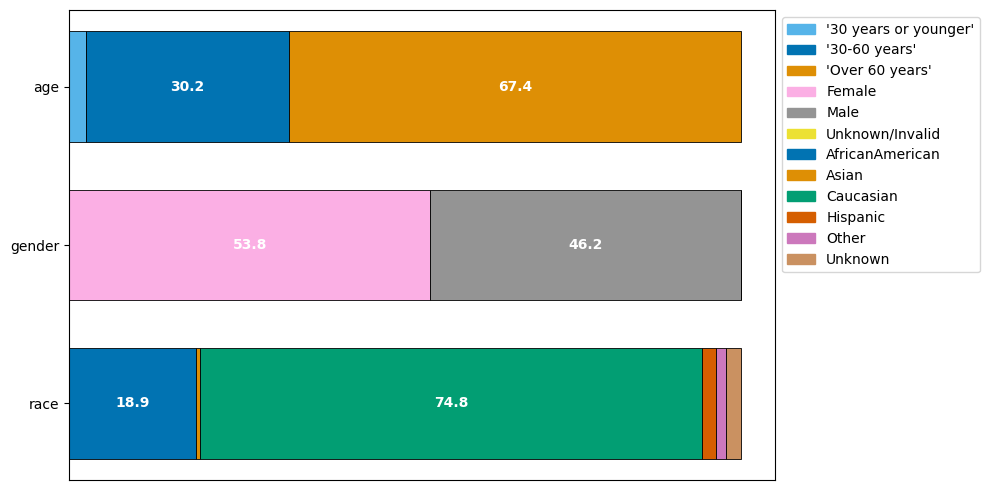

In [6]:
ct = ep.tl.CohortTracker(adata)
ct(adata)
ct.plot_cohort_barplot()

We can immediately observe how the different demographics are represented:

- The age group "Over 60 years" is overrepresented.
- The gender groups seem to be balanced between male and female, with females forming a slight majority in the dataset. Only 3 visits have a label of "Unknown/Invalid".
- The race shows how Caucasian is the most frequent in the dataset. While African American contributes a significant part of the dataset, Asian, Hispanic, Other and Unknown alltogether form less than 7% of the data.

### Mitigation strategies

- Collecting more data (the first choice whenever possible)
    - Pro: Improving coverage
    - Con: Expensive, time-consuming, maybe not feasible
- Merging small groups
    - Pro: Information across groups shared
    - Con: Can mask differences between groups
- Dropping smaller groups
    - Pro: Methods do not suggest knowledge about underrepresented groups if there is not enough data available to generate such
    - Con: Lack of representation, "[harm of erasure](https://fairlearn.org/main/user_guide/fairness_in_machine_learning.html)"

Here, **for the algorithmic bias example we will:**

* merge the three smallest race groups *Asian*, *Hispanic*, *Other* (similar to [Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/))

* drop the gender group *Unknown/Invalid*, because the sample size is so small that no meaningful assessment is possible

### Further analyses options

To get deeper understanding of the represented population, this data could be compared to the demographics at the geographic region under observation, at the time of the recording.

## Filtering bias

Filtering bias emerges when the criteria used to include or exclude records in the analysis are not clearly defined or are applied inconsistently, potentially leading to a non-representative sample of the original population.
This bias can obscure the true relationships between variables by systematically removing certain patient groups or information based on arbitrary or non-transparent criteria.
For instance, if multiple filtering steps are conducted to clean the data or select specific cohorts without adequately documenting the reasons or thresholds for these decisions, it may be difficult to replicate the study or assess the validity of its findings, thus compromising the reliability of the conclusions drawn.

### Example

Consider below an example where one filters to the subgroup of *[Medicare](https://www.hhs.gov/answers/medicare-and-medicaid/what-is-the-difference-between-medicare-medicaid/index.html)* recipients.
*Medicare* is only available to people over the age of 65 and younger individuals with severe illnesses.

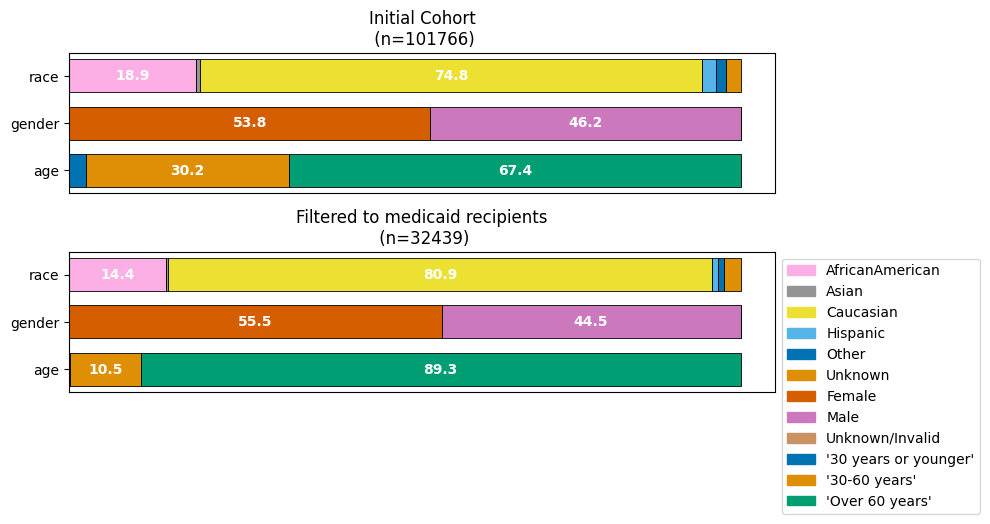

In [8]:
adata_filtered = adata.copy()

ct = ep.tl.CohortTracker(adata_filtered, columns=["age", "gender", "race"])
ct(adata_filtered, label="Initial Cohort")

adata_filtered = adata_filtered[
    adata_filtered.X[:, adata_filtered.var_names == "medicare"] == True
]
ct(adata_filtered, label="Filtered to medicaid recipients")
ct.plot_cohort_barplot(subfigure_title=True)

ehrapy allows for a visual tracking of filtering steps and associated demographics.

While we would expect that our medicare-recipients filtered dataset will consist predominantly of patients over 60 years, we might not have expected that the imbalance of the different reported race groups is aggraveted.

### Mitigation strategies
- Carefully monitor and evaluate the filtering strategies by tracking the cohort
- Examine key variables of the patient population representation in the dataset

### Further analyses options
With the filtering steps being crucial to any analysis performed, assessing the sensitivity of the modelling process to for example different filtering thresholds can be insightful; Revisiting the filtering and analysis choices if unexpected cohort composition changes occur can be necessary.

## Surveillance bias

Surveillance bias occurs when the likelihood of detecting a condition or outcome is influenced by the intensity or frequency of monitoring, leading to an overestimation of the association between exposure and outcome.
This bias is particularly prevalent in studies where certain groups are more closely observed than others, resulting in a higher detection rate of conditions in these groups regardless of actual prevalence.
For instance, individuals in a clinical trial may receive more rigorous testing and follow-up compared to the general population, thus appearing to have higher rates of certain conditions or side effects.

### Example

Hemoglobin A1c (HbA1c) is an important measure of glucose control, which is widely applied to measure performance of diabetes care ([Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

Strack et al. highlight that the measurement of HbA1c at the time of hospital admission offers an opportunity to assess the current diabetes therapy efficacy, but is only done in 18.4% of patients in the inpatient setting.
Here, we can observe that differences between the patient admission type seem to exist: Namely, it appears to be measured more frequently for emergency admissions than for referrals.

In [7]:
ep.ad.move_to_obs(adata, ["A1Cresult", "admission_source_id"], copy_obs=True)
adata.obs["A1Cresult_measured"] = ~adata.obs["A1Cresult"].isna()

2024-04-08 09:50:31,067 - root INFO - Added `['A1Cresult', 'admission_source_id']` to `obs`.


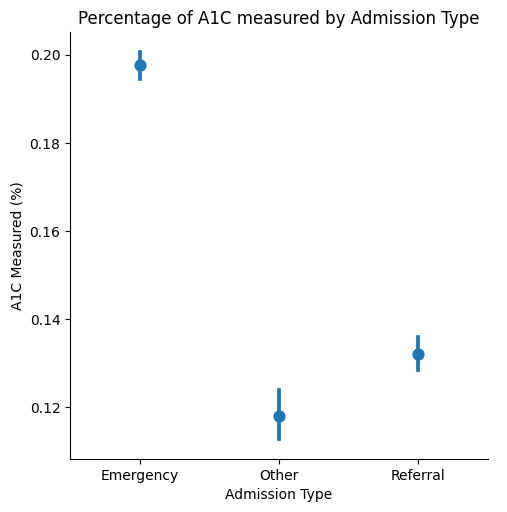

In [15]:
sns.catplot(
    y="A1Cresult_measured",
    x="admission_source_id",
    data=adata.obs,
    kind="point",
    ci=95,
    dodge=True,
    join=False,
)
plt.xlabel("Admission Type")
plt.ylabel("A1C Measured (%)")
plt.title("Percentage of A1C measured by Admission Type")
plt.show()

### Mitigation strategies
- Take particular care when drawing collective conclusions on patients experiencing different degrees of surveillance

### Further analyses options
To understand what the reasons for differences in surveillance are, in detailed studies discussing the protocols and clinical practice which is in place, as well as differently surveilled cohorts in the dataset can improve our understanding and the quality of drawn conclusions.

## Missing data bias

Missing data bias refers to the distortion in analysis results caused by non-random absence of data points. [Rubin (1976)](https://academic.oup.com/biomet/article-abstract/63/3/581/270932) classified missing data into three categories:
- Missing Completely at Random (MCAR) where the probability of a value being missing is the same for all cases
- Missing at Random (MAR) where the probability of a value being missing is depends on other observed variables
- Missing Not at Random (MNAR) where the probability of a value being missing depends on variables that are not present in the dataset

Each type affects the data and subsequent analyses differently, with MCAR having the least impact since the missingness is unrelated to the study variables or outcomes, whereas MAR and NMAR can introduce significant bias in an analysis.
For instance, if patients with more severe symptoms are less likely to have complete records (NMAR), analyses may underestimate the severity and impact of certain conditions.

### Example

We showcase this bias on the Diabetes-130 dataset, where we introduce missing data in the `num_medications` variable
1. According to an MCAR mechanism
2. According to an MAR mechanism

We first inspect the distribution of the `num_medications` variable:

In [71]:
# reload dataset
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["num_medications", "time_in_hospital"], copy_obs=True)

# TableOne for summary
TableOne(adata.obs, columns=["num_medications"], categorical=[])

2024-04-08 10:48:30,190 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `101766` x `24`.
2024-04-08 10:48:30,208 - root INFO - Added `['num_medications', 'time_in_hospital']` to `obs`.


,,Missing,Overall
n,,,101766
"num_medications, mean (SD)",,0,16.0 (8.1)


The original dataset does not contain missing values in this variable.
A histogram can give more insight into the distribution of this variable:

In [72]:
def hist_plot_num_medication(adata_to_plot, title, has_missing):
    num_medications = adata_to_plot.X[:, adata_to_plot.var_names == "num_medications"]
    mean_value = np.nanmean(num_medications)
    median_value = np.nanmedian(num_medications)
    std_value = np.nanstd(num_medications)

    plt.hist(num_medications, bins=10, alpha=0.5)

    missing_hint = " (nan ignored)" if has_missing else ""
    plt.axvline(
        mean_value,
        color="r",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean{missing_hint}: {mean_value:.2f}",
    )
    plt.axvline(
        median_value,
        color="g",
        linestyle="dashed",
        linewidth=1,
        label=f"Median{missing_hint}: {median_value:.2f}",
    )
    plt.axvline(
        mean_value + std_value,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"Stdev{missing_hint}: {std_value:.2f}",
    )
    plt.axvline(mean_value - std_value, color="b", linestyle="dashed", linewidth=1)
    plt.xlabel("Num. Medications")
    plt.ylabel("Num. Visits")
    plt.title(title)
    plt.legend()

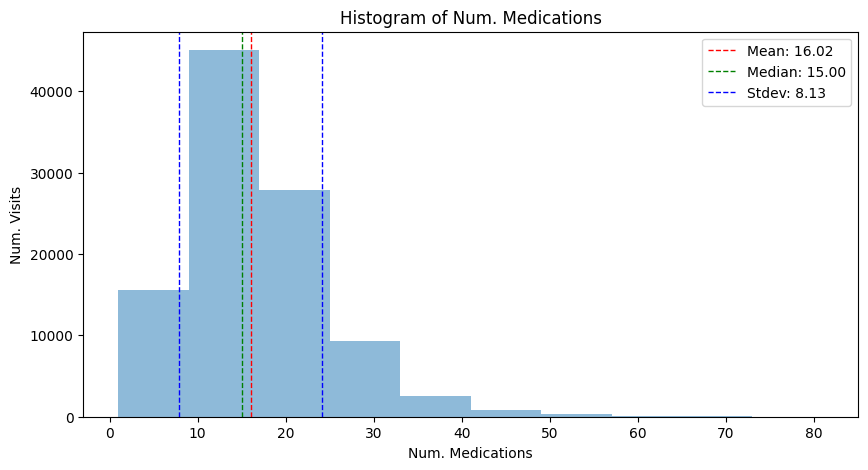

In [73]:
hist_plot_num_medication(adata, "Histogram of Num. Medications", has_missing=False)

#### MCAR
We now introduce random missingness in the `num_medications` variable, causing 30% of the data to be missing

In [47]:
# create reproducible MCAR missing values
rng = np.random.default_rng(2)
mcar_mask = rng.choice([True, False], size=len(adata), p=[0.3, 0.7])
# create a new AnnData with these missing values
adata_mcar = adata.copy()
adata_mcar.X[mcar_mask, adata_mcar.var_names == "num_medications"] = np.nan

We can see that under the MCAR mechanism, the shape of the distribution, its mean and its variance here do not systematically deviate:

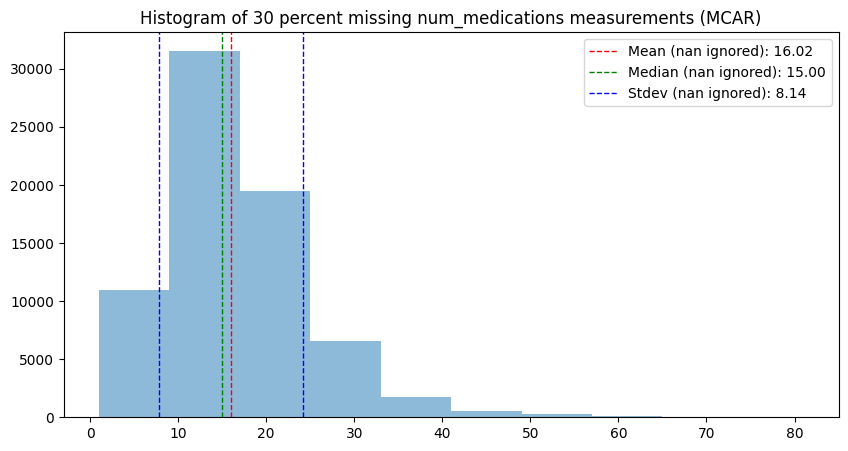

In [48]:
hist_plot_num_medication(
    adata_mcar,
    "Histogram of 30 percent missing num_medications measurements (MCAR)",
    has_missing=True,
)

[Little's MCAR test](https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722) is a statistical test, with the null hypothesis being that the data is MCAR, available in ehrapy;
Care is to be taken when interpreting such results, as the practical value of such statistical tests is unclear [van Buuren (2018)](https://stefvanbuuren.name/fimd/).
We consider the relationship of two variables of interest in this example:

In [79]:
pvalue = ep.pp.mcar_test(
    adata_mcar[:, adata_mcar.var_names.isin(["num_medications", "time_in_hospital"])]
)
print(f"pvalue of Little's MCAR test: {pvalue:.2f}")

pvalue of Little's MCAR test: 0.71


/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])


With a p-value of 0.71, we obtain no indication of the data being not MCAR: its important to note that this is not a prove of the data being MCAR. Rather, low p-values should spark attention in particular. See cite schouten[]() for a more detailed discussion.

#### MAR

We now introduce missingness in the `num_medications` variable, according to an MNAR mechanism: we take the `time_in_hospital` variable to have an impact on the probability of the `num_medications` variable: that is, we generate a synthetic example where the probability of the `num_medications` variable being missing is larger, the longer the `time_in_hospital` is.
This simulates a situation where the medication sheet would get lost at one point during the patients stay, with longer stays making it more probable to have the sheet lost somewhen along the way.

In [49]:
# Scale the time_in_hospital variable
continuous_values = np.array(
    adata.obs["time_in_hospital"] - np.mean(adata.obs["time_in_hospital"])
) / np.std(adata.obs["time_in_hospital"])

# Convert continuous values to probabilities using the logistic function
probabilities = 1 / (1 + np.exp(-continuous_values))
probabilities

# Generate boolean array based on probabilities
rng = np.random.default_rng(2)
boolean_array = rng.binomial(1, probabilities).astype(bool)

# Create a new AnnData object
adata_mar = adata.copy()

# generate a mar masked dataset
adata_mar.X[boolean_array, adata_mar.var_names == "num_medications"] = np.nan

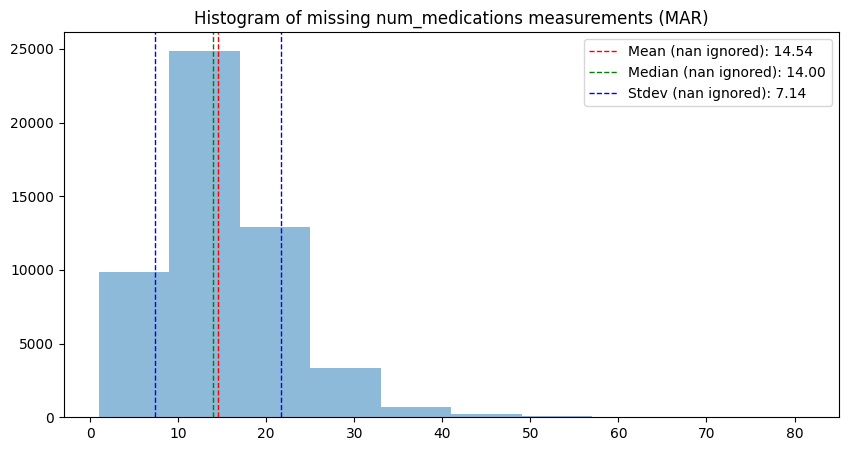

In [51]:
hist_plot_num_medication(
    adata_mar,
    "Histogram of missing num_medications measurements (MAR)",
    has_missing=True,
)

We can see that under the MAR mechanism, the shape of the distribution, its mean and its variance do systematically deviate from the complete case.
This is different from the MCAR case.
The mean and median droppped from 16.02 and 15.0 to 14.54 and 14.00, respectively. Also, the standard deviation changed form 8.14 to 7.14.

Such a scenario illustrates that we do have interest in imputing missing data, in a meaningful way.

We can again use Little's Test to evaluate the missing data behaviour between our two variables of interest, on our synthetic MAR data:

In [82]:
pvalue = ep.pp.mcar_test(
    adata_mar[:, adata_mar.var_names.isin(["num_medications", "time_in_hospital"])]
)
print(f"pvalue of Little's MCAR test: {pvalue:.2f}")

pvalue of Little's MCAR test: 0.00


/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])


Here, the pvalue of (rounded) 0.00 according to Little's Test should make us reject our Null Hypothesis being the data is MCAR with respect to these two variables: Indeed, we know by our constructed example that the data is missing according to an MAR mechanism between these two variables.

### Mitigation strategies
How to deal with missing data in general is an extensive field of research.
TODO:
Insert joke on not having it.
Refer to van buuren's book for more.
A few things should mention: no puerly statistical for MNAR; use exploratory data analysis: talk with experts. do impuation -> following chapter.
- Employ systematic statistical tests for data missingness such as Little's test.
- Try to find covariances between measured and potentially external features to differentiate between MNAR and MAR data.


In [ ]:
# TODO: a test like littles which can do categorical variables, too?

In [ ]:
import pyampute as pa

# check non-random missingness
from pyampute.exploration.mcar_statistical_tests import MCARTest

mc = MCARTest("ttest")

data = np.random.randn(6, 2)
data[0:3, 1] = np.nan
print(data)
df = pd.DataFrame(data)

print(mc.little_mcar_test(df))

[[-0.70318731         nan]
 [-0.32181433         nan]
 [ 0.20666447         nan]
 [-0.55725071  0.33721701]
 [ 1.54883597 -1.37073656]
 [ 1.4252914  -0.27946391]]
0.000581189489253342


/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])


In [13]:
from scipy.stats import ttest_ind

a = data[0:3, 0]
b = data[3:, 0]
ttest_ind(a, b, equal_var=True)

NameError: name 'data' is not defined

### Further analyses steps

Discuss potential mechanisms causing data missingness; Apply particular care when doing imputation, and potentially evaluate different imputation methods and compare results.

Little's test on some data where we know what kind of type it should be...? Only working on numerical data is an issue

## Imputation bias

Imputation bias, a specific form of algorithmic bias, occurs when the process used to estimate and fill in missing values introduces systematic differences between the imputed values and the true values.
Here, the underlying missing data mechanism (see section on missing data bias) and the choice of the imputation method together cause the manifestation of bias during imputation.

When the data is MCAR, mean, median, or mode imputation for continuous variables does not affect the location of the overall distribution of this continuous variable: However, it introduces typically an underestimation of the variance of the data.
In the MAR case, mean imputation of continuous variables introduces bias into the overall distribution of the variable: both its location and variance can be significantly biased.

See [van Buuren (2018)](https://stefvanbuuren.name/fimd/) for a detailed discussion.

### Example

We showcase this bias on the Diabetes-130 dataset, where we introduce missing data in the `num_medications` variable
1. According to an MCAR mechanism
2. According to an MAR mechanism

We first inspect the distribution of the `num_medications` variable:

### MCAR missing data and imputation
We now introduce random missingness in the `num_medications` variable, causing 30% of the data to be missing


In [25]:
# create reproducible MCAR missing values
rng = np.random.default_rng(2)
mcar_mask = rng.choice([True, False], size=len(adata), p=[0.3, 0.7])
# create a new AnnData with these missing values
adata_mcar = adata.copy()
adata_mcar.X[mcar_mask, adata_mcar.var_names == "num_medications"] = np.nan

We can see that under the MCAR mechanism, the shape of the distribution, its mean and its variance here do not systematically deviate:

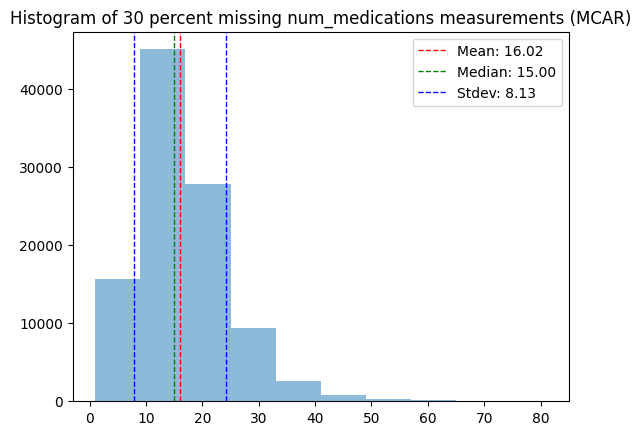

In [35]:
hist_plot_num_medication(
    adata_mcar,
    "Histogram of 30 percent missing num_medications measurements (MCAR)",
    has_missing=True,
)

However, many algorithms and analysis procedures require complete data, that is no missing values.
We showcase here how mean imputation behaves for the MCAR setting:

In [36]:
ep.pp.simple_impute(adata_mcar, var_names=["num_medications"], strategy="mean")

Quality control metrics missing. Calculating...

TypeError! Setting quality control metrics to nan. Did you encode your data?

Output()

We can see immediately how the overall location of the distribuation is not affected by mean imputation in the MCAR case: however, we can see that the variance now gets severly underestimated: the standard deviation dropped from to 8.1 in the original data to 6.8 in the imputed data.

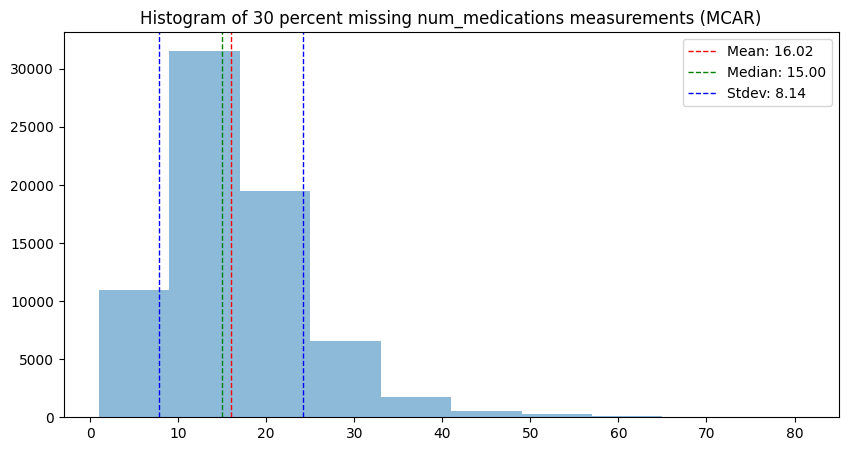

In [53]:
hist_plot_num_medication(
    adata_mcar,
    "Histogram of 30 percent missing num_medications measurements (MCAR)",
    has_missing=False,
)

### MAR missing data imputation

We now introduce missingness in the `num_medications` variable, according to an MNAR mechanism: we take the `time_in_hospital` variable to have an impact on the probability of the `num_medications` variable: that is, we generate a synthetic example where the probability of the `num_medications` variable being missing is larger, the longer the `time_in_hospital` is.
This simulates a situation where the medication sheet would get lost at one point during the patients stay, with longer stays making it more probable to have the sheet lost somewhen along the way.

In [3]:
# scale the time_in_hospital variable
continuous_values = np.array(
    adata.obs["time_in_hospital"] - np.mean(adata.obs["time_in_hospital"])
) / np.std(adata.obs["time_in_hospital"])

# Convert continuous values to probabilities using the logistic function
probabilities = 1 / (1 + np.exp(-continuous_values))
probabilities

# Generate boolean array based on probabilities
rng = np.random.default_rng(2)
boolean_array = rng.binomial(1, probabilities).astype(bool)

# generate a mar masked dataset
adata.X[boolean_array, adata.var_names == "num_medications"] = np.nan

We can see that under the MAR mechanism, the shape of the distribution, its mean and its variance do systematically deviate from the complete case.
This is different from the MCAR case.
The mean and median droppped from 16.02 and 15.0 to 14.5 and 14.0, respectively. Also, the standard deviation changed form 8.14 to 7.14.

Such a scenario illustrates that we do have interest in imputing missing data, in a meaningful way.

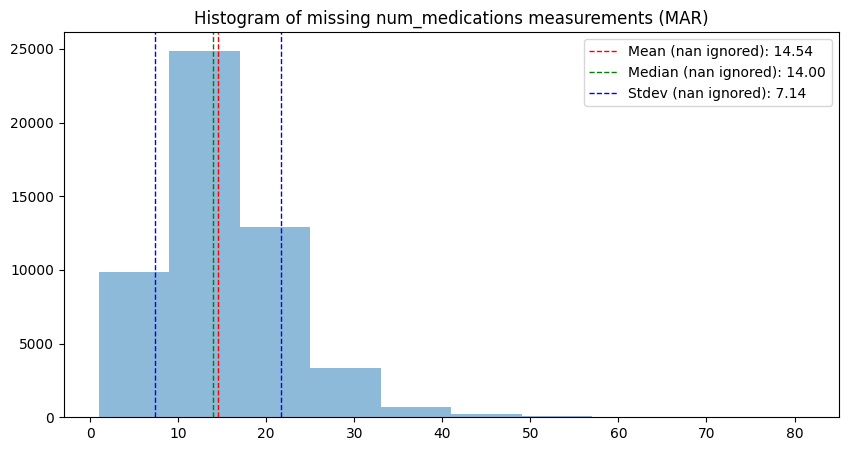

In [57]:
hist_plot_num_medication(
    adata_mar,
    "Histogram of missing num_medications measurements (MAR)",
    has_missing=True,
)

The mean imputation, which yielded a valid estimate of the mean in the MCAR case, now is not a valid imputation anymore:

In [24]:
adata_mean_imputed = ep.pp.simple_impute(
    adata, var_names=["num_medications"], strategy="mean", copy=True
)

Quality control metrics missing. Calculating...

TypeError! Setting quality control metrics to nan. Did you encode your data?

Output()

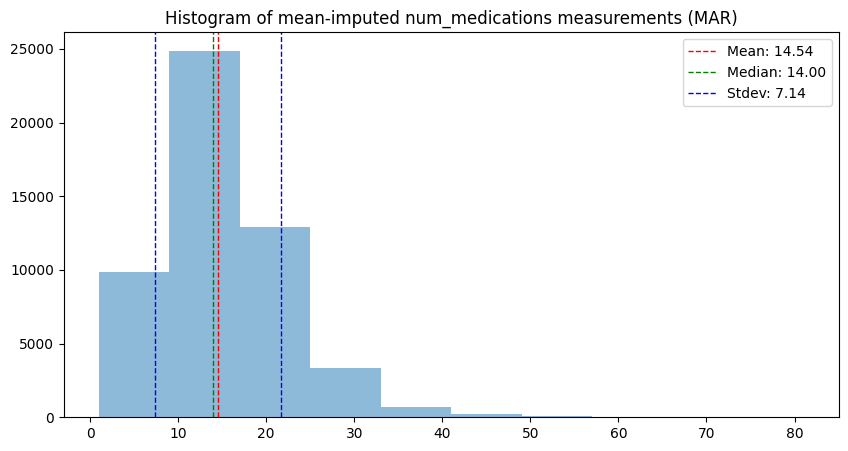

In [56]:
hist_plot_num_medication(
    adata_mar,
    "Histogram of mean-imputed num_medications measurements (MAR)",
    has_missing=False,
)

Now, more sophisticated approaches are needed: Multiple imputation is a commonly used and very powerful imputation method.
We show here how, a still somewhat simple, KNN-Imputation with the `time_in_hospital` information, shows superior results to the mean imputation, while still underestimating the effect of the MAR mechanism:

In [4]:
# adata_medication_hospital_time = sc.AnnData(adata.X[:, adata.var_names.isin(["num_medications", "time_in_hospital"])], obs=adata.obs, var=adata.var[adata.var_names.isin(["num_medications", "time_in_hospital"])])
adata_medication_hospital_time = ep.ad.df_to_anndata(
    pd.DataFrame(
        adata.X[:, adata.var_names.isin(["time_in_hospital", "num_medications"])],
        columns=["time_in_hospital", "num_medications"],
    )
)
adata_medication_hospital_time.shape

2024-04-06 12:44:01,049 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `101766` x `2`.


In [5]:
# takes 3.5 mins on my machine, mean: 15.95, std: 6.3
adata_knn_impute = ep.pp.knn_impute(adata_medication_hospital_time, copy=True)

Quality control metrics missing. Calculating...

scikit-learn-intelex is not available. Install via pip install scikit-learn-intelex  for faster imputations.

Output()

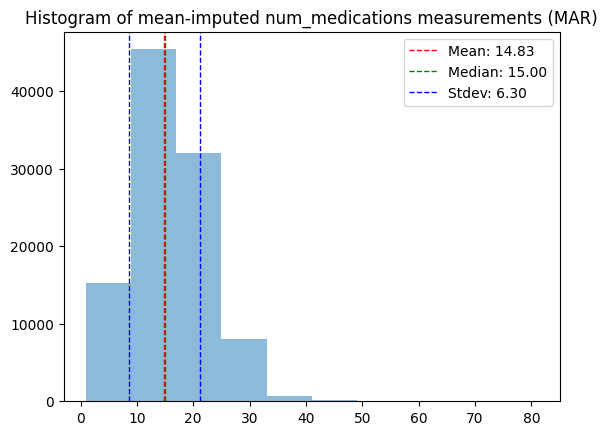

In [20]:
plt.hist(
    adata_knn_impute.X[:, adata_knn_impute.var_names == "num_medications"],
    bins=10,
    alpha=0.5,
)

mean_value = np.mean(
    adata_knn_impute.X[:, adata_knn_impute.var_names == "num_medications"]
)
median_value = np.median(
    adata_knn_impute.X[:, adata_knn_impute.var_names == "num_medications"]
)
std_value = np.nanstd(
    adata_knn_impute.X[:, adata_knn_impute.var_names == "num_medications"]
)

plt.axvline(
    mean_value,
    color="r",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {mean_value:.2f}",
)
plt.axvline(
    median_value,
    color="g",
    linestyle="dashed",
    linewidth=1,
    label=f"Median: {median_value:.2f}",
)
plt.axvline(
    mean_value + std_value,
    color="b",
    linestyle="dashed",
    linewidth=1,
    label=f"Stdev: {std_value:.2f}",
)
plt.axvline(mean_value - std_value, color="b", linestyle="dashed", linewidth=1)
plt.title("Histogram of knn-imputed num_medications measurements (MAR)")
plt.legend()

plt.show()

Are there other ways to measure uncertainty? We should look into the literature and potentially implement things. Maybe also https://github.com/theislab/ehrapy/issues/652? What about time aware imputation?

### Mitigation Strategies

### Further Analyses Options


## Algorithmic bias

Algorithmic bias occurs when algorithms systematically favor certain groups over others, often due to biases inherent in the data used to train these algorithms.
This can result in unequal treatment recommendations, risk predictions, or health outcomes assessments across different demographics, such as race, gender, or socioeconomic status.
For instance, an algorithm trained predominantly on data from one ethnic group may perform poorly or inaccurately predict outcomes for individuals from underrepresented groups, exacerbating disparities in healthcare access and outcomes.

### Example: Recommending patients for *high-risk care management* programs
Here, we follow an example from the [Fairlearn SciPy 2021 Tutorial:  Fairness in AI Systems](https://github.com/fairlearn/talks/tree/main/2021_scipy_tutorial), in a shortened and slightly modified analysis.

#### The Scenario

Here, we consider the task of predicting **hospital readmission within 30 days** from a dataset of hospital data of diabetic patients.
Such a quick readmission is viewed as proxy that the patient needed more assistance at release time and is therefore our target variable.

We follow the decision in the earlier work to measure the
- balanced accuracy to investigate the performance of the algorithm
- selection rate to investigate how many patients are recommended for care
- false negative rate to investigate how many patients are considered would have missed the needed assistance

#### Bias/Fairness Consideration
We want to investigate whether and which patient subgroups of the demographic variable `race` are negatively affected by a model.

#### Mitigation
We explore a toolkit offering algorithmic mitigation methods to account for negatively affected subgroups.

Disclaimer: We consider a small example on real data: while the insight of how potential biases can affect a model is real, the example is too limited in scope and evaluation to be considered a solution to a real world problem.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.metrics import MetricFrame, false_negative_rate, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

#### Data Preparation
We load the dataset, and put variables we are not interested to pass to our model but into the `.obs` field.
We build a binary label `readmit_30_days` indicating whether a patient has been readmitted in <30 days.

In [74]:
adata_algo = ep.dt.diabetes_130_fairlearn(
    columns_obs_only=[
        "race",
        "gender",
        "age",
        "readmitted",
        "readmit_binary",
        "discharge_disposition_id",
    ]
)
adata_algo.obs["readmit_30_days"] = adata_algo.obs["readmitted"] == "<30"

2024-03-20 17:47:01,323 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `101766` x `18`.


In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.
In this dataset, gender is primarily reported binary, with 54% *Female* and 46% *Male*, and 3 samples annotated as *Unknown/Invalid*

In [75]:
TableOne(adata_algo.obs, columns=["race", "gender", "age"])

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

#### Decision: How to address smaller group sizes?
We have seen different strategies to address smaller group sizes in the selection bias part.

- For the `race` variable, we will follow the strategy of using buckets to merge small groups *Other*, *Spanish*, *Asian*.
- For the `gender` variable, we will remove the *Unknown/Invalid* annotated samples, as no meaningful assessment is possible with this sample size

In [76]:
# aggregate small groups
adata_algo.obs["race_all"] = adata_algo.obs["race"]
adata_algo.obs["race"] = adata_algo.obs["race"].replace(
    {"Asian": "Other", "Hispanic": "Other"}
)

# drop gender group Unknown/Invalid
adata_algo = adata_algo[adata_algo.obs["gender"] != "Unknown/Invalid", :].copy()
ep.ad.move_to_x(adata_algo, "gender")

2024-03-20 17:47:02,871 - root INFO - Added `['gender']` features to `X`.


AnnData object with n_obs × n_vars = 101763 × 19
    obs: 'race', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all'
    var: 'ehrapy_column_type'

We now prepare our variables required for model training, and encode categorical variables in the data.

In [77]:
# here different from fairlearn: I think they mix unknown (encoded as an own category) vs nan (encoded as all-0)
adata_algo = ep.pp.encode(
    adata_algo,
    autodetect=True,
)

# grab target variable
y = adata_algo.obs.loc[:, ["readmit_30_days"]].copy()

# grab features
X = pd.DataFrame(adata_algo.X, columns=adata_algo.var_names, index=y.index)

# grab sensitive variable
A = adata_algo.obs.loc[:, ["race"]].copy()

2024-03-20 17:47:04,107 - root INFO - The original categorical values `['admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']` were added to uns.


Output()

2024-03-20 17:47:05,057 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.


2024-03-20 17:47:05,091 - root INFO - Updated the original layer after encoding.


2024-03-20 17:47:05,300 - root INFO - The original categorical values `['admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']` were added to obs.


/Users/eljasroellin/Documents/ehrapy_clean/ehrapy/ehrapy/preprocessing/_encoding.py:271: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  encoded_ann_data.X = encoded_ann_data.X.astype(np.number)


We split our data into train and test groups.

In [78]:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.5, stratify=y, random_state=0
)

To account for label imbalance of our target variable `Y_train` with more `False` than `True` cases, we (uniformly random) subsample the major `False` samples:

In [79]:
Y_train.value_counts()

readmit_30_days
False              45203
True                5678
Name: count, dtype: int64

In [80]:
def resample_dataset(X_train, Y_train, A_train):
    negative_ids = Y_train[~Y_train.astype(bool).values].index
    positive_ids = Y_train[Y_train.values].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train


A_train.columns = ["race"]
X_train_balanced, Y_train_balanced, A_train_balanced = resample_dataset(
    X_train, Y_train, A_train
)

Y_train_balanced.value_counts()

readmit_30_days
False              5678
True               5678
Name: count, dtype: int64

#### Model Training

In [81]:
unmitigated_pipeline = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("logistic_regression", LogisticRegression(max_iter=1000)),
    ]
)

In [82]:
unmitigated_pipeline.fit(X_train_balanced, Y_train_balanced.astype(bool))

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

We can inspect our model's coefficients:

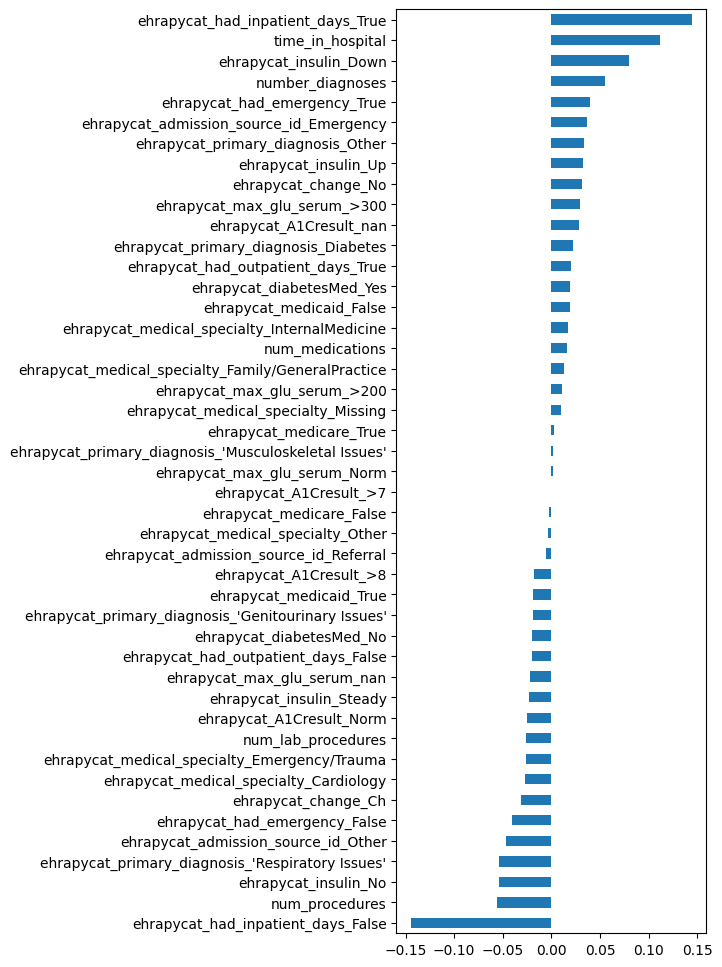

In [83]:
coef_series = pd.Series(
    data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0],
    index=X.columns,
)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

To check our model performance on the test data, we first look at the ROC curve of this binary classifier:

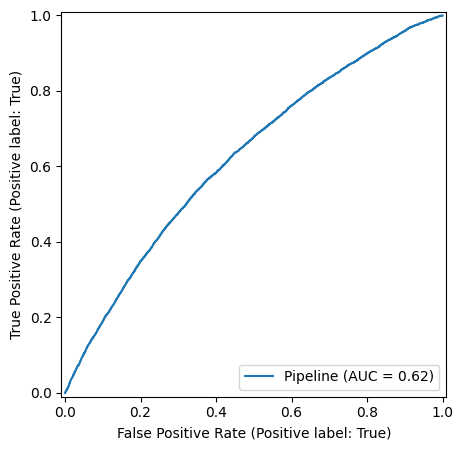

In [84]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:, 1]
Y_pred = unmitigated_pipeline.predict(X_test)

RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test, Y_test.astype(bool));

We observe an overall balanced accuracy of 0.59, well about random chance, albeit showing that the simplified model and assumptions are far from a reliable prediction.

In [85]:
balanced_accuracy_score(Y_test.astype(bool), Y_pred.astype(bool))

Using fairlearn's MetricFrame utility, we can conveniently inspect our target model performance measurements:

In [86]:
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

mf1 = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

mf1.by_group

/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:385: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = data.groupby(all_grouping_names).apply(


,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.410342,0.415060,0.598429
Caucasian,0.386743,0.449710,0.592211
Other,0.319471,0.504950,0.597055
Unknown,0.245917,0.686747,0.536411


A barplot represents this information graphically:

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

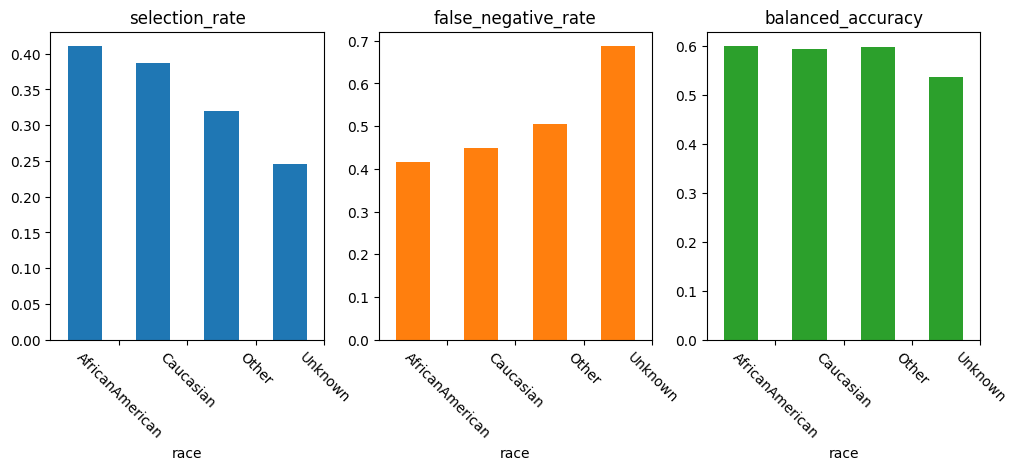

In [87]:
mf1.by_group.plot.bar(
    subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
)

We can observe that performance is worst for the "Other" and "Unkown" subgroups across all metrics.
Particularly relevant with respect to fairlearn's conception of fairness as harming a subgroup, the low selection rate and the worse False Negative rate in this smaller subgroups is highly relevant:

The model is biased towards a worse performance of these groups.

#### Mitigation: fairlearns ThresholdOptimizer

Now we instantiate ThresholdOptimizer with the logistic regression estimator:

In [88]:
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)
postprocess_est.fit(
    X_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced
)
Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test,
)
pd.concat(
    [mf1.by_group, metricframe_postprocess.by_group],
    keys=["Unmitigated", "ThresholdOptimizer"],
    axis=1,
)

/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:385: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = data.groupby(all_grouping_names).apply(


Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican       0.410342            0.415060          0.598429   
Caucasian             0.386743            0.449710          0.592211   
Other                 0.319471            0.504950          0.597055   
Unknown               0.245917            0.686747          0.536411   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican           0.450940            0.381084          0.594696  
Caucasian                 0.493624            0.349826          0.588266  
Other                     0.477788            0.346535          0.597109  
Unknown                   0.503630            0.337349          0.585987

In [89]:
Y_pred_mitig = postprocess_est.predict(X_test, sensitive_features=A_test)
balanced_accuracy_score(Y_test.astype(bool), Y_pred_mitig.astype(bool))

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

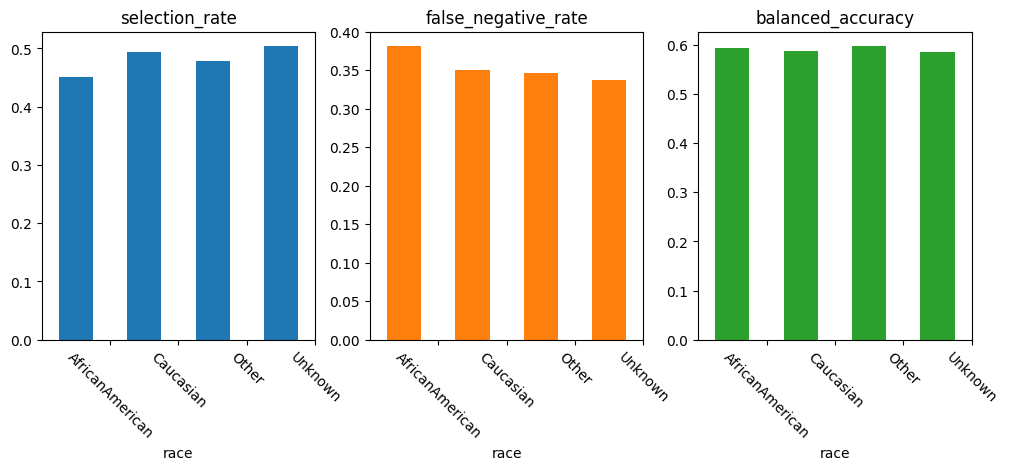

In [90]:
metricframe_postprocess.by_group.plot.bar(
    subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
)
# postprocess_performance = figure_to_base64str(plt)

TODO
- write nice comments
- That performance can increase for others
- Note that having inpatient days is the single most important classification feature - using only this features performs ~equally to the model using all the data (fairlearn didnt check in their tutorial). Can ehrapy be used instead of the other thing to showcase that? That'd be a proper finding for an exploratory analysis I think?

In [99]:
postprocess_est.interpolated_thresholder_.

InterpolatedThresholder(estimator=Pipeline(steps=[('preprocessing',
                                                   StandardScaler()),
                                                  ('logistic_regression',
                                                   LogisticRegression(max_iter=1000))]),
                        interpolation_dict={'AfricanAmerican': {'operation0': [>0.4769891205274154],
                                                                'operation1': [>0.48307480512424816],
                                                                'p0': 0.03166666666666649,
                                                                'p1': 0.9683333333333335},
                                            'Caucasian': {'operation0': [>0.457959259078592...
                                                          'p0': 0.8516666666666667,
                                                          'p1': 0.14833333333333332},
                                            'Other': {'operation0': [>0.45239296406182816],
                                                      'operation1': [>0.5457500809983491],
                                                      'p0': 0.9784313725490196,
                                                      'p1': 0.021568627450980427},
                                            'Unknown': {'operation0': [>0.3660304500115267],
                                                        'operation1': [>0.4266621116841258],
                                                        'p0': 0.07500000000000014,
                                                        'p1': 0.9249999999999998}},
                        predict_method='predict_proba', prefit=True)

## Synthetic EHR dataset

The following biases are difficult to demonstrate with the diabetes 130 dataset.
Therefore, we resort to a synthetic dataset.

## Information bias

Information bias refers to inaccuracies or inconsistencies in the data recorded, which can stem from errors in how health information is documented, interpreted, or coded.
Such biases can lead to misclassifications, either overestimating or underestimating the association between exposures and outcomes.
For instance, if a condition is under-documented due to lack of standardized diagnostic criteria across EHR systems, studies might underestimate its prevalence and the effectiveness of treatments.

Just classical quality control. Show that there might be one group that is more susceptible to data information collection biases. Maybe show that some minority gets data measured with some cheap ass bad instrument that records mistakes, whereas rich people get the perfect new machine.


## Coding bias

Coding bias in EHR data arises when there are discrepancies or inconsistencies in how medical conditions, procedures, and outcomes are coded, often due to variation in the understanding and application of coding systems by different healthcare providers.
This can lead to misrepresentation of patient conditions, treatments received, and outcomes, affecting the reliability of research and analyses conducted using this data.
For example, two providers may code the same symptom differently, leading to challenges in accurately aggregating and comparing data across EHR systems.

Need to find some overlap in ICD encodings that can lead to this issue? Maybe consider showing that Mondo is great but simplifies some things that can lead to biases.

## Attrition bias

Attrition bias emerges when there is a systematic difference between participants who continue to be followed up within the healthcare system and those who are lost to follow-up or withdraw from the system.
This can lead to skewed outcomes or distorted associations in longitudinal studies, as the data may no longer be representative of the original population.
For example, if patients with more severe conditions are more likely to remain engaged in the healthcare system for ongoing treatment, studies may overestimate the prevalence of these conditions and their associated healthcare outcomes.

Find a way to get statistics on this and plot it.

## Confounding bias

Confounding bias arises when an outside variable, not accounted for in the analysis, influences both the exposure of interest and the outcome, leading to a spurious association between them.
This can distort the true effect of the exposure on the outcome, either exaggerating or underestimating it.
For example, if a study investigating the effect of a medication on disease progression fails to account for the severity of illness at baseline, any observed effect might be due more to the initial health status of the patient than to the medication itself.

Have a domain expert that helps with that -> try to get as much information about the data collection as possible.
Or try to find some correlations -> TBD.

## Normalization bias

Normalization biases arise when the methods used to standardize or normalize data across different scales or distributions inadvertently distort the underlying relationships or magnitudes in the data.
This can occur if the normalization technique does not account for intrinsic variability within subgroups or assumes a uniform distribution where it does not exist, leading to misleading interpretations of the data's true structure.
For example, applying the same normalization method to clinical measurements that vary widely between demographic groups (e.g., pediatric vs. adult populations) can mask important physiological differences and affect the accuracy of subsequent analyses.

1. Show how the distribution of some demographics and some actual measurement values -> show that they follow different distributions
2. Show somehow how normalizing them with the same method jointly isn't necessarily the smartest idea
3. Show that ehrapy normalization functions can be applied per column.
4. Show that ehrapy keeps the original values in `originals`

### Discussion and Conclusion

Datasets of Electronic Health Records are snapshots with limited information and typically contain multiple biases. To leverage the data available, it is important to describe and discuss such limitations. The combination of ehrapy and fairlearn helps in doing so in a reproducible, transparent manner.

Although we can use a variety of software tools to help us, biases and fairness is a sociotechnical challenge, so mitigations cannot be purely technical. These challenges needd to be supported by processes and practices, including government regulation and organizational incentives.